# Digital Earth Australia Intertidal workflow

## Getting started
Set working directory to top level of repo to ensure links work correctly:

In [1]:
cd ..

/home/jovyan/Robbi/dea-intertidal


Install additional packages directly from the requirements file

In [ ]:
pip install -r requirements.in --quiet

### Load packages

In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from intertidal.utils import load_config
from intertidal.elevation import elevation
from intertidal.extents import extents
from intertidal.exposure import pixel_exp
from intertidal.tidal_bias_offset import bias_offset
from intertidal.tidelines import tidal_offset_tidelines



## Setup


### Set analysis parameters

In [3]:
study_area = 'Gladstone'  #1215 #340
## 815: South Gladstone, QLD

## Nidem variables
fname = 'testing_Gladstone'
start_year = 2019
end_year = 2021
resolution = 10
crs = "epsg:32753"
ndwi_thresh = 0.1
include_s2 = True
include_ls = True
filter_gqa = False

## Exposure variables
## Set the frequency to run the tidal model e.g '30min' or '1h'
modelled_freq = '30min'

# Generate range of times covering entire period of satellite record for exposure and bias/offset calculation
all_timerange = pd.date_range(
    start=f'{start_year}-01-01 00:00:00',
    # start=time_start,
    # end=time_end,
    end=f'{end_year}-12-31 00:00:00',
    freq=modelled_freq)

# Load analysis params from config file
config = load_config(config_path='configs/dea_intertidal_config.yaml')

### Load study area grid cell

In [ ]:
# # Albers grid cells used to process the analysis
# gridcell_gdf = (
#     gpd.read_file(config['Input files']['grid_path']).to_crs(
#         epsg=4326).set_index('id'))
# gridcell_gdf.index = gridcell_gdf.index.astype(int).astype(str)
# gridcell_gdf = gridcell_gdf.loc[[str(study_area)]]

# # Create geom as input for dc.load
# geom = Geometry(geom=gridcell_gdf.iloc[0].geometry, crs='EPSG:4326')
# geom

##### Other options for loading study area

In [4]:
from odc.ui import select_on_a_map
from ipyleaflet import basemaps, basemap_to_tiles

# Plot interactive map to select area
basemap = basemap_to_tiles(basemaps.Esri.WorldImagery)
geom = select_on_a_map(height='600px',
                       layers=(basemap,),
                       center=(-26, 135),
                       zoom=4)

## Guide: for 10m2 pixels, analysis area of 90km2 takes ~XXXX mins to run full workflow on 16XL sandbox instance

Map(center=[-26, 135], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

## Intertidal workflow

### Intertidal elevation

In [19]:
ds, freq, tide_m = elevation(study_area=geom, start_year=start_year, end_year=end_year)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/8787/status,
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/8787/status,Workers: 1
Total threads: 62,Total memory: 477.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38991,Workers: 1
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/8787/status,Total threads: 62
Started: Just now,Total memory: 477.21 GiB
Comm: tcp://127.0.0.1:43443,Total threads: 62
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/39115/status,Memory: 477.21 GiB
Nanny: tcp://127.0.0.1:39953,


2023-04-06 04:36:41 INFO Study area testing: Loaded custom study area
2023-04-06 04:36:41 INFO Study area testing: Loading satellite data
/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/env/lib/python3.8/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
2023-04-06 04:37:52 INFO Study area testing: Modelling tide heights for each pixel


Creating reduced resolution tide modelling array
Modelling tides using FES2014 tide model
Reprojecting tides into original array


100%|██████████| 462/462 [00:00<00:00, 620.74it/s]
2023-04-06 04:38:02 INFO Study area testing: Masking nodata and adding tide heights to satellite data array
2023-04-06 04:38:02 INFO Study area testing: Flattening satellite data array and filtering to tide influenced pixels
2023-04-06 04:38:04 INFO Study area testing: Running per-pixel rolling median


Reducing analysed pixels from 119280 to 13823 (11.59%)


100%|██████████| 114/114 [00:12<00:00,  9.44it/s]
2023-04-06 04:38:17 INFO Study area testing: Modelling intertidal elevation and confidence
2023-04-06 04:38:18 INFO Study area testing: Successfully completed intertidal elevation modelling


Processing elevation_low
Processing elevation
Processing elevation_high


### Intertidal extents

#### Always/sometimes/never wet

Values of 0 represent always wet, 1 is the extent of the DEA intertidal product suite and 2 represents never wet

In [20]:
ds['extents'] = extents(ds.elevation, freq)

### Intertidal exposure
Calculate exposure using the script function

In [21]:
ds['exposure'], tide_cq = pixel_exp(ds.elevation, all_timerange)

Creating reduced resolution tide modelling array
Modelling tides using FES2014 tide model
Computing tide quantiles
Reprojecting tides into original array


100%|██████████| 101/101 [00:00<00:00, 361.12it/s]


### Spread and offset
Calculate the spread and high/low tide biases of input observed images as a percentage of the modelled tide heights

In [22]:
(ds['lat'], 
 ds['hat'], 
 ds['lot'], 
 ds['hot'], 
 ds['spread'], 
 ds['lt_offset'],
 ds['ht_offset']) = bias_offset(tide_m=tide_m,
                                tide_cq=tide_cq,
                                extents=ds.extents,
                                lot_hot=True,
                                lat_hat=True)

### Tideline confidence

In [23]:
(hightideline, 
 lowtideline, 
 tidelines_gdf) = tidal_offset_tidelines(extents=ds.extents,
                                         ht_offset=ds.ht_offset,
                                         lt_offset=ds.lt_offset,
                                         distance=250)

Operating in multiple z-value, single array mode


## Plot all layers

In [24]:
# Inspect contents of ds before plotting
ds

<xarray.Dataset>
Dimensions:               (x: 355, y: 336)
Coordinates:
  * x                     (x) float64 1.941e+06 1.941e+06 ... 1.944e+06
  * y                     (y) float64 -2.728e+06 -2.728e+06 ... -2.732e+06
    spatial_ref           int32 3577
    variable              <U4 'ndwi'
Data variables: (12/13)
    elevation_low         (y, x) float32 nan nan nan nan nan ... nan nan nan nan
    elevation             (y, x) float32 nan nan nan nan nan ... nan nan nan nan
    elevation_high        (y, x) float32 nan nan nan nan nan ... nan nan nan nan
    elevation_confidence  (y, x) float32 nan nan nan nan nan ... nan nan nan nan
    extents               (y, x) int16 2 2 2 2 2 2 2 2 2 2 ... 0 0 0 0 0 0 0 0 0
    exposure              (y, x) int16 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    ...                    ...
    hat                   (y, x) float64 nan nan nan nan ... 2.122 2.122 2.122
    lot                   (y, x) float32 nan nan nan ... -1.236 -1.236 -1.236
    hot                   (y, x) float32 nan nan nan nan ... 2.029 2.029 2.029
    spread                (y, x) int16 0 0 0 0 0 0 0 0 ... 82 82 82 82 82 82 82
    lt_offset             (y, x) int16 0 0 0 0 0 0 0 0 ... 14 14 14 14 14 14 14
    ht_offset             (y, x) int16 0 0 0 0 0 0 0 0 0 0 ... 2 2 2 2 2 2 2 2 2

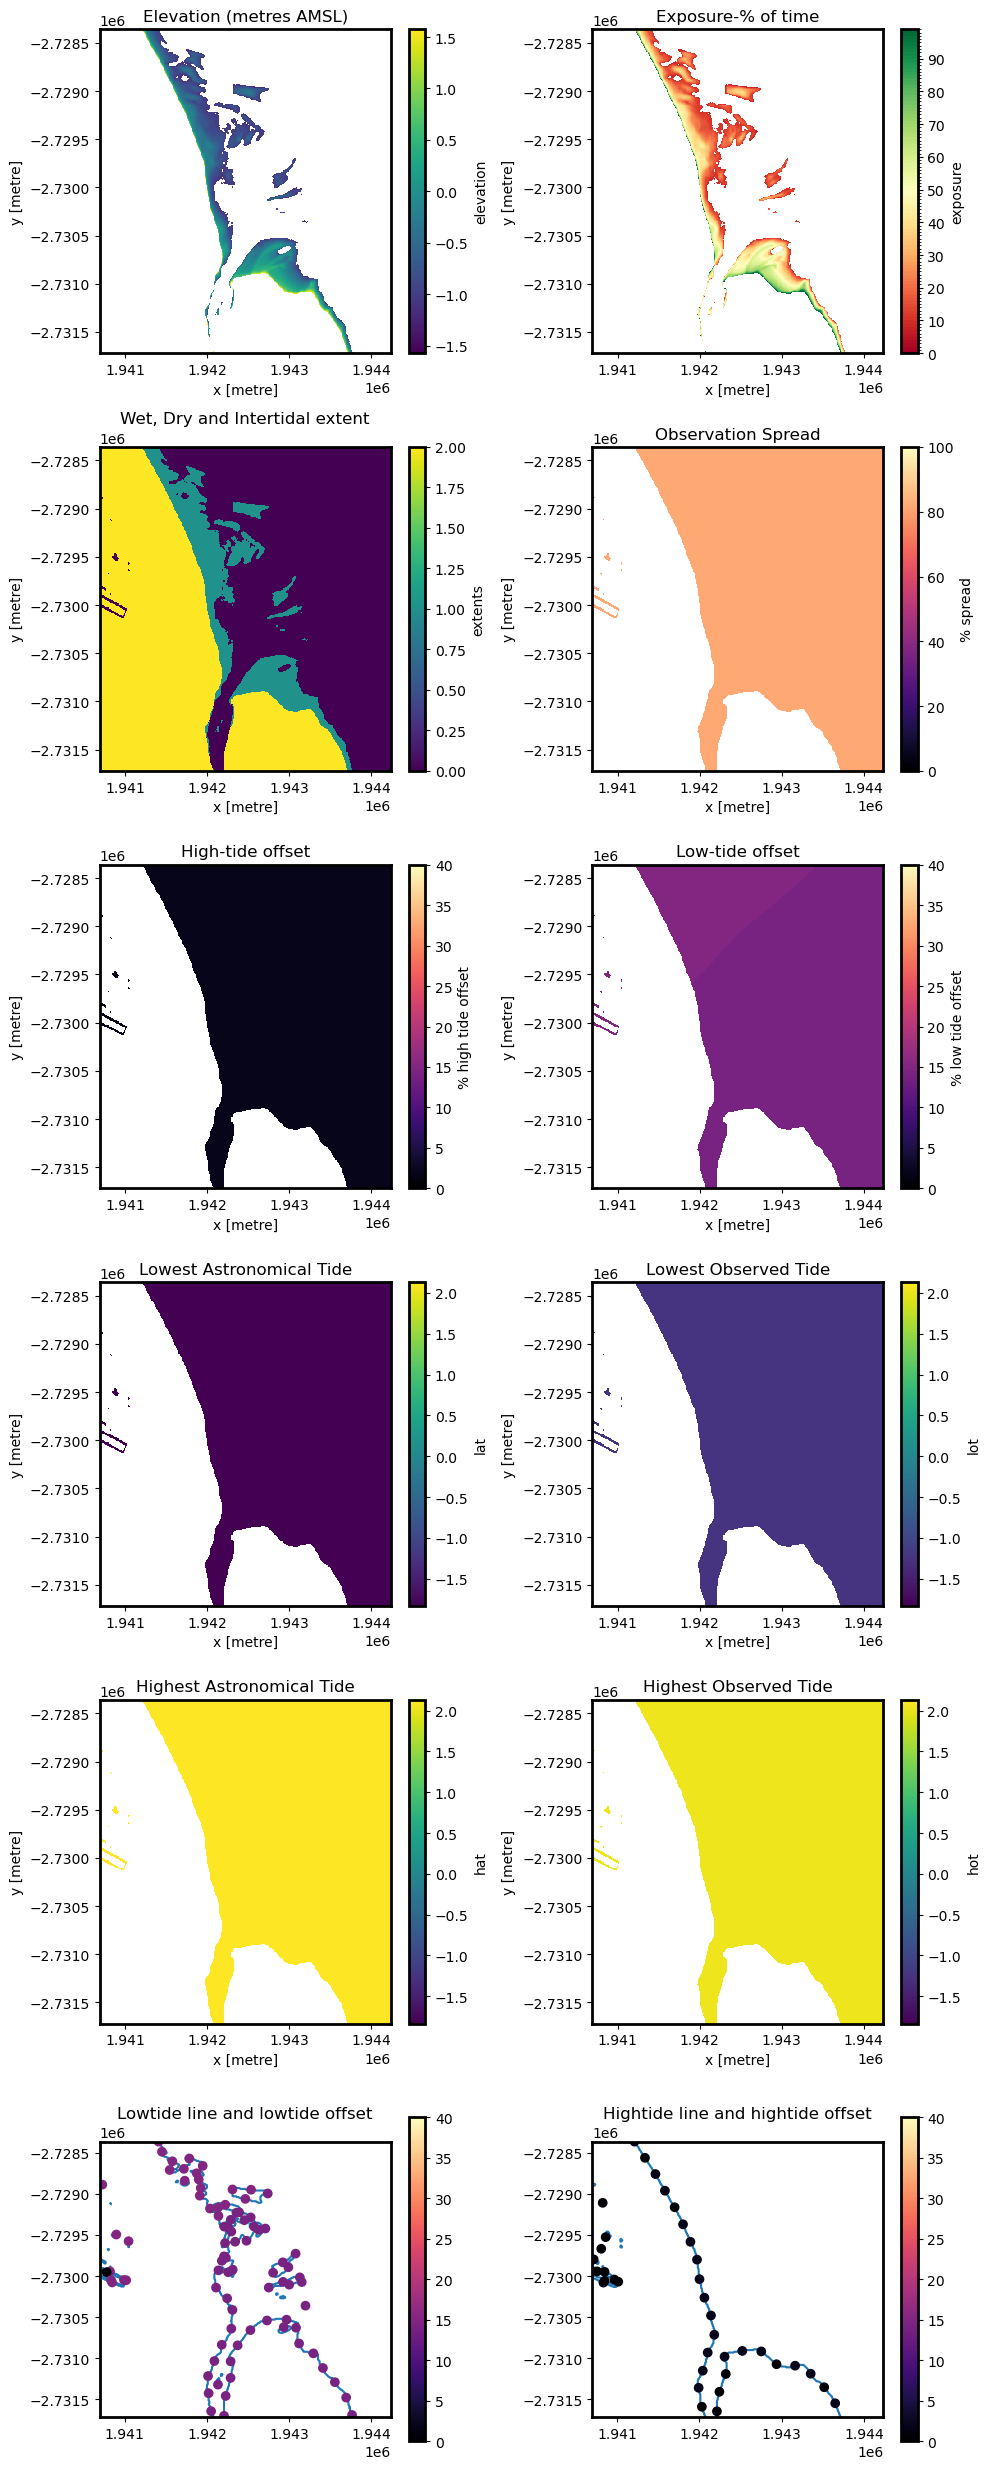

In [25]:
# Set up figure
fig = plt.figure(figsize=(10, 25))
ax1 = fig.add_subplot(6, 2, 1)
ax2 = fig.add_subplot(6, 2, 2)
ax3 = fig.add_subplot(6, 2, 3)
ax4 = fig.add_subplot(6, 2, 4)
ax5 = fig.add_subplot(6, 2, 5)
ax6 = fig.add_subplot(6, 2, 6)
ax7 = fig.add_subplot(6, 2, 7)
ax8 = fig.add_subplot(6, 2, 8)
ax9 = fig.add_subplot(6, 2, 9)
ax10 = fig.add_subplot(6, 2, 10)
ax11 = fig.add_subplot(6, 2, 11)
ax12 = fig.add_subplot(6, 2, 12)

# Plot NIDEM
ds['elevation'].plot(ax=ax1, cmap='viridis')
ax1.set_title('Elevation (metres AMSL)')

# Plot Exposure
ds['exposure'].where(ds['exposure'] > 0).plot(ax=ax2,
                                              cmap='RdYlGn',
                                              levels=np.arange(0, 100, 1))
ax2.set_title('Exposure-% of time')

# Plot the always/sometimes/never wet extents
ds['extents'].astype(np.int16).plot(ax=ax3)
ax3.set_title('Wet, Dry and Intertidal extent')

# Plot the observation spread
ds['spread'].where((ds['extents'] != 2) & (ds['spread'] > 0)).plot(
    ax=ax4, vmin=0, vmax=100, cmap='magma', cbar_kwargs={'label': '% spread'})
ax4.set_title('Observation Spread')

# Plot the high-tide offset
ds['ht_offset'].where((ds['extents'] != 2) & (ds['spread'] > 0)).plot(
    ax=ax5,
    vmin=0,
    vmax=40,
    cmap='magma',
    cbar_kwargs={'label': '% high tide offset'})
ax5.set_title('High-tide offset')

# Plot the low-tide offset
ds['lt_offset'].where((ds['extents'] != 2) & (ds['spread'] > 0)).plot(
    ax=ax6,
    vmin=0,
    vmax=40,
    cmap='magma',
    cbar_kwargs={'label': '% low tide offset'})
ax6.set_title('Low-tide offset')

# Plot the LAT
ds['lat'].where(ds['extents'] != 2).plot(ax=ax7,
                                         vmin=ds['lat'].min(),
                                         vmax=ds['hat'].max())
ax7.set_title('Lowest Astronomical Tide')

# Plot the LOT
ds['lot'].where(ds['extents'] != 2).plot(ax=ax8,
                                         vmin=ds['lat'].min(),
                                         vmax=ds['hat'].max())
ax8.set_title('Lowest Observed Tide')

# Plot the HAT
ds['hat'].where(ds['extents'] != 2).plot(ax=ax9,
                                         vmin=ds['lat'].min(),
                                         vmax=ds['hat'].max())
ax9.set_title('Highest Astronomical Tide')

# Plot the HOT
ds['hot'].where(ds['extents'] != 2).plot(ax=ax10,
                                         vmin=ds['lat'].min(),
                                         vmax=ds['hat'].max())
ax10.set_title('Highest Observed Tide')

# Plot the high and low tidelines with respective offset
ax11.set_title('Lowtide line and lowtide offset')
lowtideline.plot(column='lt_offset',
                 legend=True,
                 vmin=0,
                 vmax=40,
                 cmap='magma',
                 ax=ax11,
                 zorder=2)
tidelines_gdf.loc[[0], 'geometry'].plot(ax=ax11, zorder=1)
ax11.set_xlim(left=ds.elevation.x.min(), right=ds.elevation.x.max())
ax11.set_ylim(bottom=ds.elevation.y.min(), top=ds.elevation.y.max())

ax12.set_title('Hightide line and hightide offset')
hightideline.plot(column='ht_offset',
                  legend=True,
                  vmin=0,
                  vmax=40,
                  cmap='magma',
                  ax=ax12,
                  zorder=2)
tidelines_gdf.loc[[1], 'geometry'].plot(ax=ax12, zorder=1)
ax12.set_xlim(left=ds.elevation.x.min(), right=ds.elevation.x.max())
ax12.set_ylim(bottom=ds.elevation.y.min(), top=ds.elevation.y.max())

fig.tight_layout()
plt.show()

# Export figure
fig.savefig(f'data/interim/{fname}_{start_year}_{end_year}.png')

## Export layers

In [26]:
# Save layers as GeoTIFFs
ds.map(lambda x: x.odc.write_cog(
    fname=f"data/interim/{fname}_{start_year}_{end_year}_{x.name}.tif",
    overwrite=True))

# Export vector files
hightideline.to_crs('EPSG:4326').to_file(f'data/interim/{fname}_{start_year}_{end_year}_hightideoffset.geojson')
lowtideline.to_crs('EPSG:4326').to_file(f'data/interim/{fname}_{start_year}_{end_year}_lowtideoffset.geojson')
tidelines_gdf.to_crs('EPSG:4326').to_file(f'data/interim/{fname}_{start_year}_{end_year}_high_low_tidelines.geojson')

In [ ]:
# import fiona
# from fiona.crs import to_string
# from shapely.geometry import mapping

# schema = {
#     'geometry': 'Polygon',
#     'properties':{'id':'int'}
#     }
# ## Note: open shp and set crs as epsg:4326 in QGIS
# with fiona.open(f'./data/interim/{fname}_geom',
#                 'w', 
#                 'ESRI Shapefile', 
#                 schema,
#                 # crs=geom.crs.crs_str
#                ) as c:
#     c.write({'geometry': mapping(geom.geom),
#              'properties':{'id':123},
#              'crs' : geom.crs
#             })